# QPEP analysis

This notebook looks at the results from the qpep performance analysis in the opensand testbed.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import re

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


For each bottleneck bandwidth, I want to plot throughput (i.e. sent bps) against: delays or plr (on two different plots). On the same plot, we have qpep and plain for the 3 different file sizes. Put confidence intervals around the datapoints of one of the file sizes.

I should create a dictionnary with
```bash
bandwidths
|-plr
|--delay
|---filesize [10kbps,100kbps,10mbps]
```


In [5]:
def average_bps(file_path):
    try:
        data = np.loadtxt(file_path)
        # only take values after time is more than 100
        return np.average(data[data[:,0] > 100])
    except: 
        return 0

def get_error(file_path):
    match = re.search(r"_([.\d]*)plr_", file_path)
    if not match: 
        print(f"Error: Error not found in {file_path}")
        return None
    return match.group(1)

def get_delay(file_path):
    match = re.search(r"_(\d+?[\.\d]*?)ms_",file_path)
    if not match: 
        print(f"Error: Delay not found in {file_path}")
        return None
    return match.group(1)

def get_bandwidth(file_path):
    match = re.search(r"_(\d+?.\d+?kbps)_",file_path)
    if not match: 
        print(f"Error: Bandwidth not found in {file_path}")
        return None
    return match.group(1)

In [19]:
import matplotlib.colors as mcolors
error_percentages = [0,0.01,0.5,1] #that is in packet error
file_sizes = [1e4,1e5,1e7]#in bytes
bandwidths = [7e2,1e4,4e5]#in kbps
delays = [1,10,50,100,250]#Added delay on the satellite link (=RTT/4)

my_colours = list(mcolors.TABLEAU_COLORS.values())
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
cca = "Opensand emulation"
folder_path = "./qpep_results/18.08.23/qpep_iperf/"

# Get a list of all files in the folder
file_list = os.listdir(folder_path)
# Create dictionary to store the average for each error, rtt, and run
results = {}
for i,filename in enumerate(file_list):
    bandwidth = get_bandwidth(f'{folder_path}{filename}')
    error = get_error(f'{folder_path}{filename}')
    rtt = get_delay(f'{folder_path}{filename}')
    if bandwidth not in results:
        results[bandwidth] = {}
    if error not in results[bandwidth]:
        results[bandwidth][error] = {}
    if rtt not in results[bandwidth][error]:
        results[bandwidth][error][rtt] = {}
    file = open(f'{folder_path}{filename}','rb')
    data = pickle.load(file)
    for filesize in data.keys():
        results[bandwidth][error][rtt][filesize] = data[filesize]['sent_bps']
    file.close()

print(results)

# sort the dictionary by error key
# results[bw] = dict(sorted(results[bw].items()))

{'400000.0kbps': {'1': {'250': {'iperf_0.01mb': [322792000000.0, 253733000000.0, 383551000000.0, 297165000000.0, 158346000000.0], 'iperf_0.1mb': [20704000000.0, 913633000.0, 29268300000.0, 1342780000.0, 5835080000.0], 'iperf_10.0mb': [35268700.0, 32043800.0, 37819100.0, 39070400.0, 39396300.0]}, '100': {'iperf_0.01mb': [305420000000.0, 408487000000.0, 135603000000.0, 253733000000.0, 115637000000.0], 'iperf_0.1mb': [2336930000.0, 10444200000.0, 330060000000.0, 317548000000.0, 6874900000.0], 'iperf_10.0mb': [39766100.0, 40990000.0, 43253200.0, 34356800.0, 34238300.0]}, '1': {'iperf_0.01mb': [287830000000.0, 296498000000.0, 595941000000.0, 361236000000.0, 330060000000.0], 'iperf_0.1mb': [4606410000.0, 1837040000.0, 2904250000.0, 2179760000.0, 1649310000.0], 'iperf_10.0mb': [38363500.0, 42019200.0, 34316500.0, 35512900.0, 31370000.0]}, '10': {'iperf_0.01mb': [117595000000.0, 218265000000.0, 356117000000.0, 200215000000.0, 288082000000.0], 'iperf_0.1mb': [95350600000.0, 3444180000.0, 903029

In [40]:
def plot_bps_vs_error(results = {}, bw = '400000kbps',rtt = '1'):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt or one rtt to plot against error
    """
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    # now just plot one of the file sizes: 0.01mb
    filesize='iperf_0.01mb'
    points = np.zeros((len(results[bw]['0'][rtt].keys()),len(results[bw].keys()),4)) #we have this many different errors
    for j,error in enumerate(results[bw].keys()):
        for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        # for i, filesize in enumerate(results[bw][error][rtt]):
            points[i,j,:] = float(error)/100 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        ax.errorbar(points[i,:,0],points[i,:,1], yerr=[abs(points[i,:,1]-points[i,:,2]), abs(points[i,:,3]-points[i,:,1])], fmt='none', capsize=5,alpha=0.5,color=my_colours[i%len(my_colours)])
        ax.plot(points[i,:,0],points[i,:,1],label=f'filesize = {filesize}',marker='x', markerfacecolor="none", markersize = '4',linestyle='',color=my_colours[i%len(my_colours)])
    ax.text(0.40, 0.95, f"{rtt}ms, {bw}", transform=ax.transAxes, fontsize="small",
            verticalalignment='top', bbox=props)
    ax.legend(title=f"Model, delay = {4*float(rtt)}ms",loc='upper left',fontsize="small", markerscale=0.6, ncols=2)
    ax.set_xlabel("Packet error rate")
    plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
    ax.set_ylabel("Throughput(Mbps)")
    ax.grid()
    plt.show()
    return

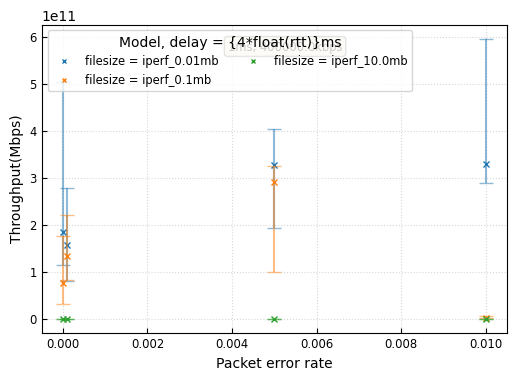

In [41]:
plot_bps_vs_error(results,bw='400000.0kbps',rtt='1')

In [44]:
# Now plot the throughput as a function of the delay
def plot_bps_vs_delay(results = {}, bw = '400000kbps',error = '0'):
    """Plot the qpep experiments results
    Specify either one error to plot against rtt
    """
    fig, ax = plt.subplots(1,1,figsize=(6,4))
    # Maybe assert that it is a valid rtt
    # assert(results[bw][].keys)
    # Points is an array containing the points to plot
    # every row is a point, which has: an x-value (the error rate), a y-value(the send bps median), a lower error, an upper error
    # now just plot one of the file sizes: 0.01mb
    points = np.zeros((len(results[bw][error]['1'].keys()),len(results[bw][error].keys()),4)) #we have this many different errors
    for j,rtt in enumerate(results[bw]['0'].keys()):
        for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        # for i, filesize in enumerate(results[bw][error][rtt]):
            points[i,j,:] = float(error)/100 , np.median(results[bw][error][rtt][filesize]), np.min(results[bw][error][rtt][filesize]), np.max(results[bw][error][rtt][filesize])
    for i, filesize in enumerate(results[bw]['0'][rtt].keys()):
        ax.errorbar(points[i,:,0],points[i,:,1], yerr=[abs(points[i,:,1]-points[i,:,2]), abs(points[i,:,3]-points[i,:,1])], fmt='none', capsize=5,alpha=0.5,color=my_colours[i%len(my_colours)])
        ax.plot(points[i,:,0],points[i,:,1],label=f'filesize = {filesize}',marker='x', markerfacecolor="none", markersize = '4',linestyle='',color=my_colours[i%len(my_colours)])
    ax.text(0.40, 0.95, f"{rtt}ms, {bw}", transform=ax.transAxes, fontsize="small",
            verticalalignment='top', bbox=props)
    ax.legend(title=f"Model, delay = {4*float(rtt)}ms",loc='upper left',fontsize="small", markerscale=0.6, ncols=2)
    ax.set_xlabel("delay")
    plt.tick_params(axis='both', direction='in',labelsize="small", grid_alpha=0.5, grid_linestyle=':')
    ax.set_ylabel("Throughput(Mbps)")
    ax.grid()
    plt.show()
    return

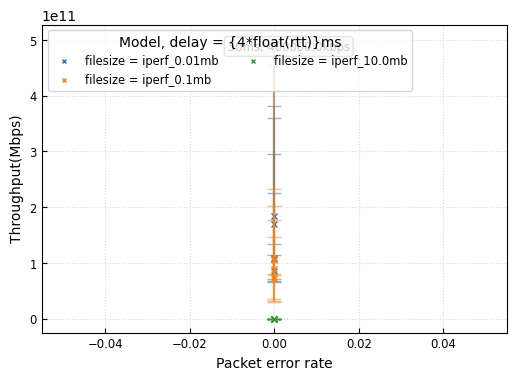

In [45]:
plot_bps_vs_delay(results,bw='400000.0kbps',error='0')